# Compare to the Lane et al 

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 150

In [3]:
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [4]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the data

In [5]:
EXPERIMENT =        'one_timestep_forecast' # '2020_04_23:190425_one_timestep_forecast' 
TRUE_EXPERIMENT =   'one_timestep_forecast'
TARGET_VAR =        'discharge_spec'
STATIC_DATA_FILE =  'data.nc' # '2020_04_23:112630_data.nc_'
DYNAMIC_DATA_FILE = 'data.nc'
N_EPOCHS = 100

# assert (data_dir / f"RUNOFF/models/{EXPERIMENT}").exists()
assert (data_dir / f"RUNOFF/features/{TRUE_EXPERIMENT}").exists()

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / f'RUNOFF/features/{TRUE_EXPERIMENT}/{DYNAMIC_DATA_FILE}')

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

ds['station_id'] = ds['station_id'].astype(int)

In [7]:
# 13 test stations
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

# Open FUSE Models

In [8]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

# Open fuse summary scores

In [9]:
[d.name for d in (data_dir / "FUSE/Summary_Scores").iterdir()]

['.footer.html',
 'Best_Scores.txt',
 'GLUEbounds_N_Sims.txt',
 '.header.html',
 'Best_NSE_Seasonal.txt',
 'NSE_decomposed_scores.txt']

In [10]:
headers = performance_scores = pd.read_table(data_dir / "FUSE/Summary_Scores/Best_Scores.txt").loc[:2]
print(headers.iloc[0].values)
print(headers.iloc[1].values)
print(headers.iloc[2].values)

['This is a summary of the best performance scores attained for each catchment and model, out of the 10,000 Monte-Carlo sampled parameter sets.']
['Scores are best NSE, relative bias (Rel_Bias), relative difference in the standard deviation (Rel_std), Pearsons correlation coefficient (Pearson_r) and Mean square error (MSE).']
['These are calculated individually for FUSE model structures 060 (TOPMODEL), 230 (ARNO/VIC), 342 (PRMS), 426 (SACRAMENTO).']


In [11]:
def fix_name(string: str):
    string = string.replace("_060", "_TOPMODEL")
    string = string.replace("_230", "_VIC")
    string = string.replace("_342", "_PRMS")
    string = string.replace("_426", "_SACRAMENTO")
    return string

performance_scores = pd.read_csv(data_dir / "FUSE/Summary_Scores/Best_Scores.txt", skiprows=4)

# fix the column names
performance_scores.columns = [fix_name(c) for c in performance_scores.columns]

# get matching stations
performance_scores = performance_scores.loc[np.isin(performance_scores["Gauge_ID"], ds["station_id"])]

performance_scores.head()

,Gauge_ID,NSE_TOPMODEL,NSE_VIC,NSE_PRMS,NSE_SACRAMENTO,Relative_Bias_TOPMODEL,Relative_Bias_VIC,Relative_Bias_PRMS,Relative_Bias_SACRAMENTO,Relative_diff_std_TOPMODEL,...,Relative_diff_std_PRMS,Relative_diff_std_SACRAMENTO,Correlation_TOPMODEL,Correlation_VIC,Correlation_PRMS,Correlation_SACRAMENTO,MSE_TOPMODEL,MSE_VIC,MSE_PRMS,MSE_SACRAMENTO
0,10002,0.676705,0.760394,0.729084,0.755280,0.000140,0.000053,0.000002,0.000010,0.000004,...,0.000007,-0.000050,0.870051,0.873570,0.868442,0.887319,0.682056,0.505497,0.571552,0.516288
1,10003,0.614465,0.794624,0.751196,0.756433,-0.000215,-0.000001,0.000037,-0.000046,0.000065,...,-0.000109,0.000017,0.843056,0.913798,0.910523,0.920012,0.719625,0.383347,0.464408,0.454634
2,1001,0.755836,0.764714,0.788691,0.806047,-0.000001,0.000031,0.000011,0.000030,0.000080,...,-0.000005,-0.000004,0.882052,0.889214,0.893842,0.899833,0.993700,0.957569,0.859985,0.789353
3,101002,0.616119,0.696603,0.554009,0.724537,0.000004,0.000092,-0.000106,-0.000049,0.000153,...,0.012961,-0.000103,0.849858,0.865308,0.862584,0.874849,0.466656,0.368818,0.542160,0.334860
5,101005,0.638900,0.671685,0.445414,0.706599,0.000068,0.000004,0.169143,0.000098,-0.000071,...,0.009819,0.000080,0.866859,0.868605,0.872395,0.878581,0.422756,0.384373,0.649279,0.343498


# NOTE: only test performance on Certain Periods (OPTIONAL)

In [12]:
TEST_2004_2008 = False
TEST_1998_2008 = True
if TEST_2004_2008:
    fuse_ds = fuse_ds.sel(time=slice('2004-01-01', '2009-01-01'))
elif TEST_1998_2008:
    fuse_ds = fuse_ds.sel(time=slice('1998-01-01', '2009-01-01'))
fuse_ds

<xarray.Dataset>
Dimensions:          (station_id: 841, time: 4018)
Coordinates:
  * station_id       (station_id) int64 1001 2001 2002 ... 101005 102001 106001
  * time             (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    SimQ_TOPMODEL    (station_id, time) float64 ...
    SimQ_ARNOVIC     (station_id, time) float64 ...
    SimQ_PRMS        (station_id, time) float64 ...
    SimQ_SACRAMENTO  (station_id, time) float64 ...

In [13]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["target_var_original"]
).rename("discharge_spec")

In [14]:
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

In [16]:
# fuse_data

# Hydrographs

In [12]:
df = fuse_data.sel(time=(fuse_data['time.year'] == 2008).values).isel(station_id=10).to_dataframe().drop('station_id', axis=1)
df = df[["discharge_spec"] + [c for c in df.columns if "spec" not in c]]

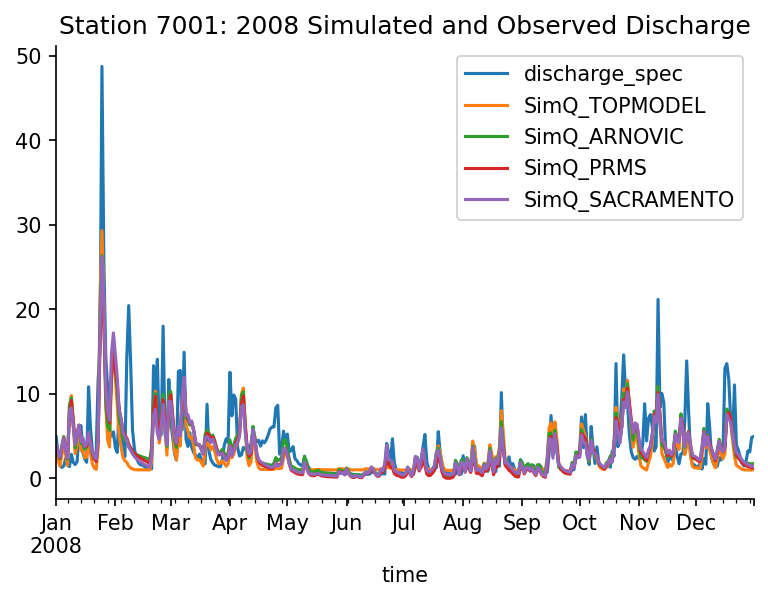

In [13]:
station_id = int(fuse_data.isel(station_id=10).station_id.values)
df.plot()
ax = plt.gca()
ax.set_title(f"Station {station_id}: 2008 Simulated and Observed Discharge")
sns.despine()

In [18]:
fuse_data = fuse_data.rename({'discharge_spec': 'obs'})
fuse_data.to_netcdf(data_dir / 'RUNOFF/fuse_data.nc')

### Check on 10 random stations that the data is correct

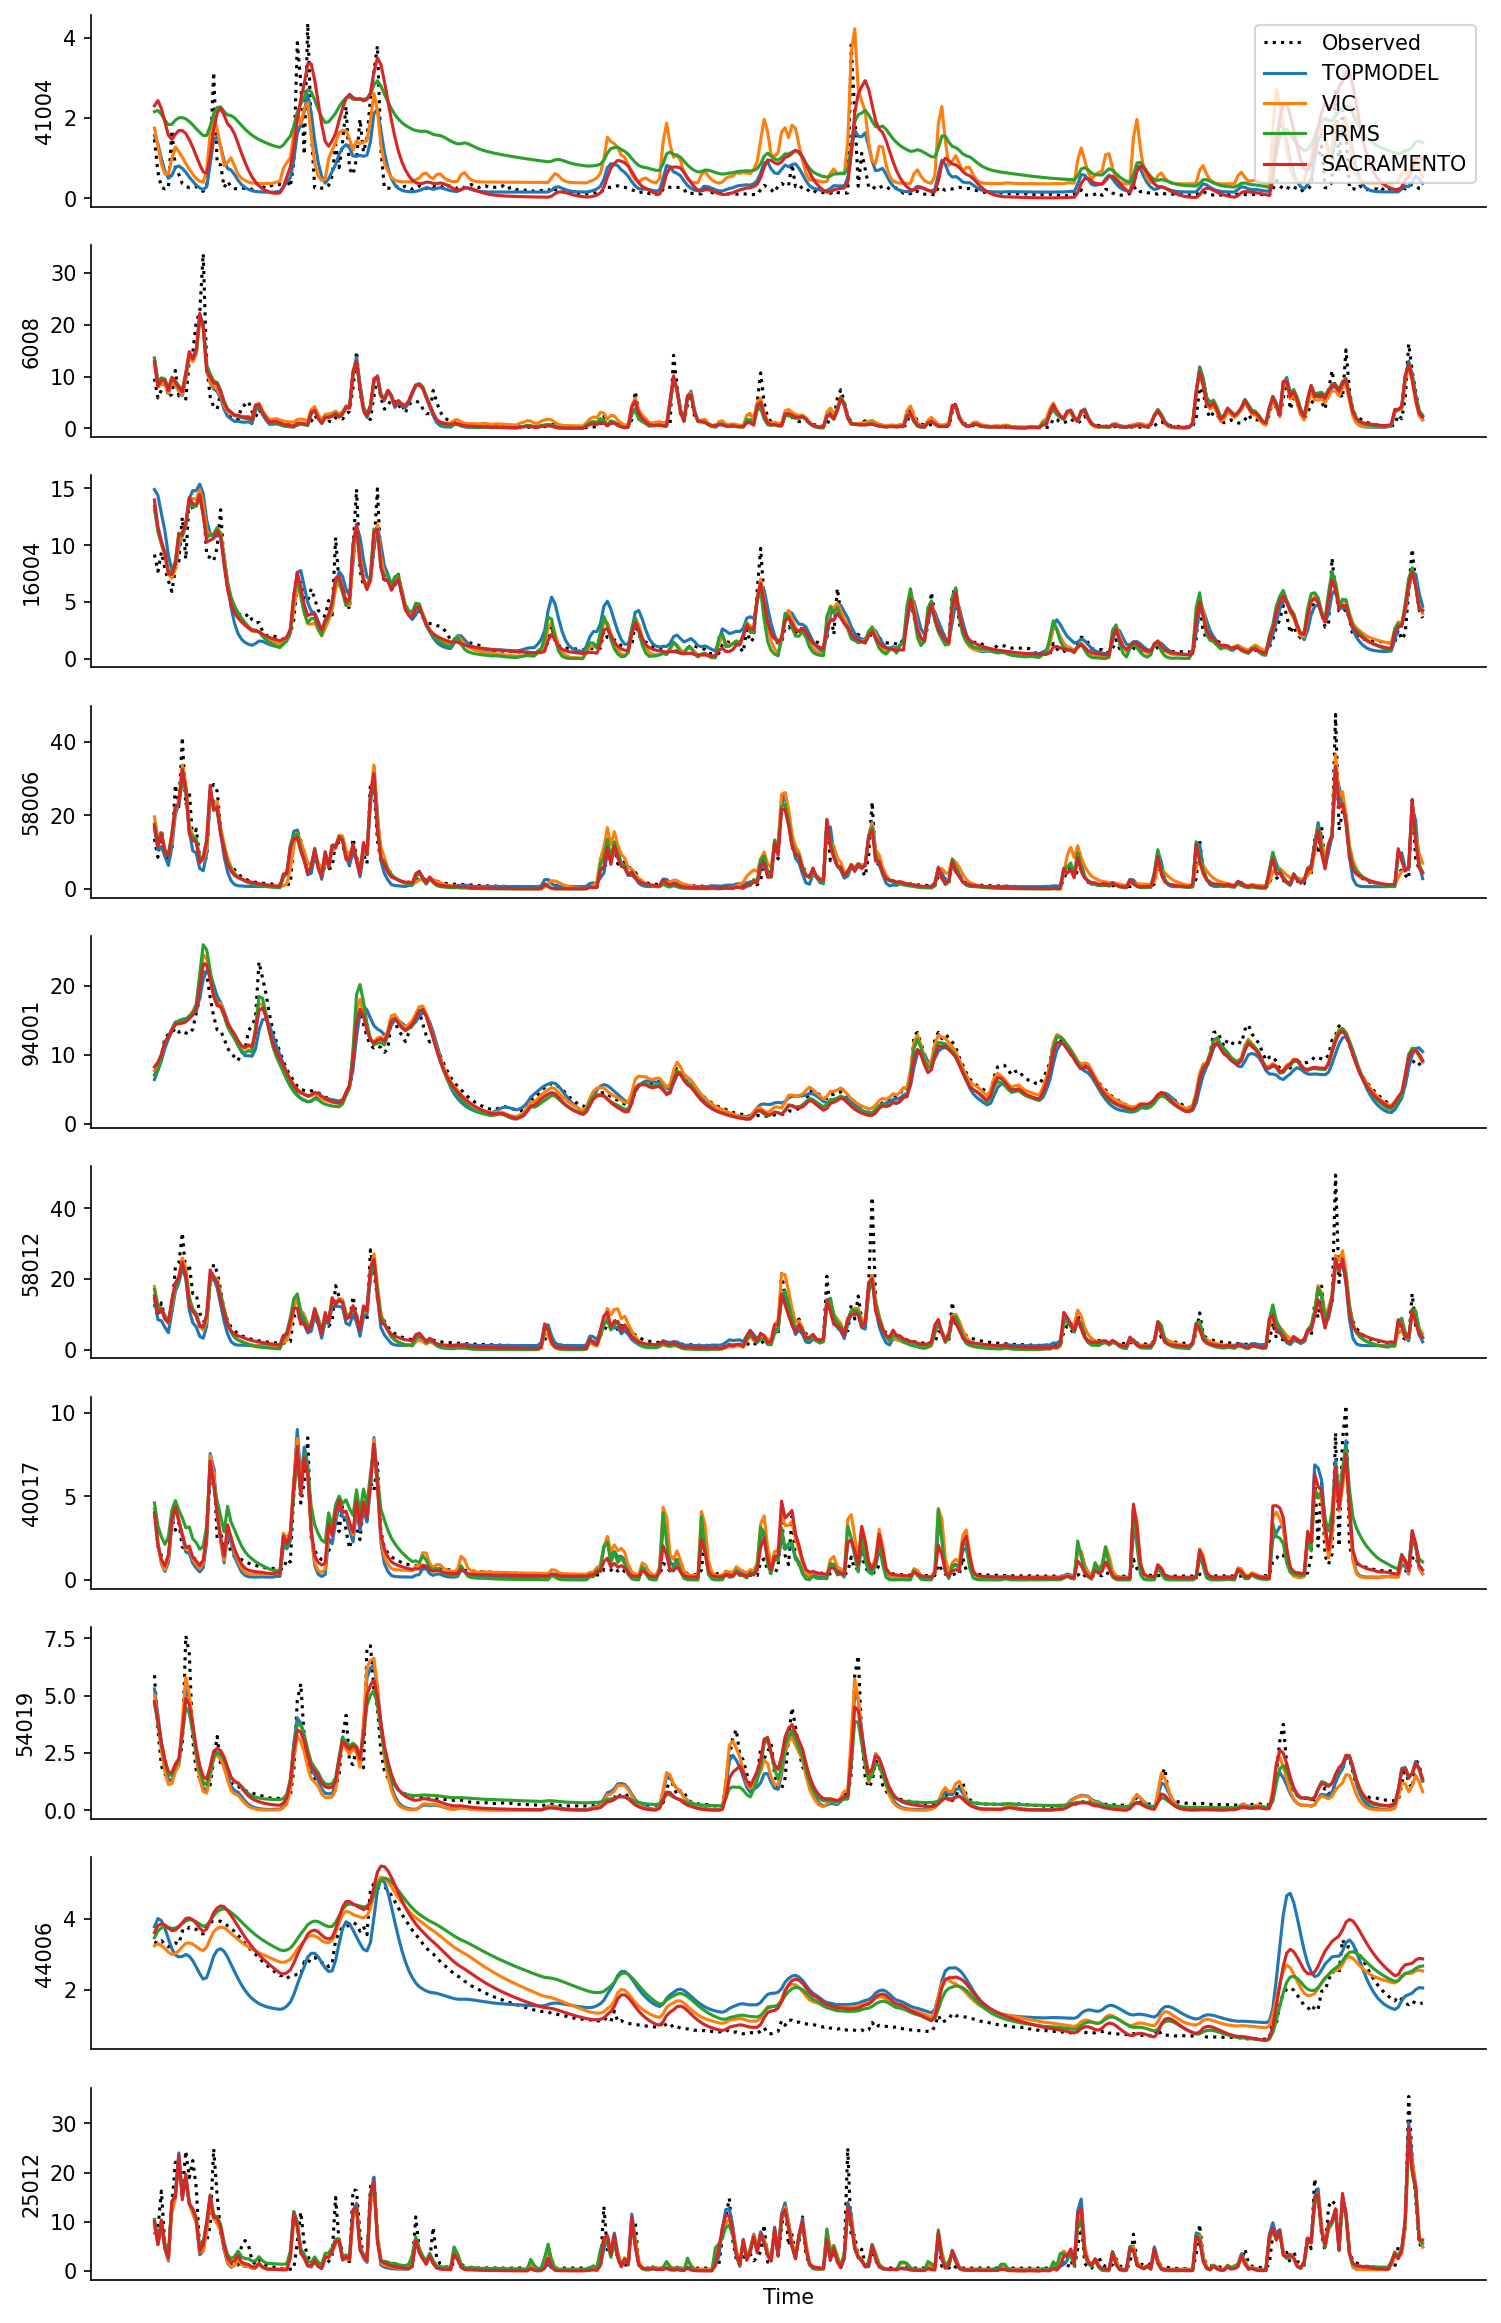

In [19]:
stations = np.random.choice(fuse_data.station_id.values, 10)

f, axs = plt.subplots(10, 1, figsize=(12, 2*10))
for ix, station in enumerate(stations):
    ax = axs[ix]
    df = fuse_data.sel(station_id=station, time=(fuse_data['time.year'] == 2007)).to_dataframe()
    ax.plot(np.arange(len(df)), df["obs"], color="k", ls=":", label="Observed")
    ax.plot(np.arange(len(df)), df["SimQ_TOPMODEL"], color=sns.color_palette()[0], label="TOPMODEL")
    ax.plot(np.arange(len(df)), df["SimQ_ARNOVIC"], color=sns.color_palette()[1], label="VIC")
    ax.plot(np.arange(len(df)), df["SimQ_PRMS"], color=sns.color_palette()[2], label="PRMS")
    ax.plot(np.arange(len(df)), df["SimQ_SACRAMENTO"], color=sns.color_palette()[3], label="SACRAMENTO")
    ax.set_xticks([])
    ax.set_xticklabels([""])
    ax.set_ylabel(f"{station}")
    if ix == 0:
        ax.legend()
    if ix == 9:
        ax.set_xlabel("Time")
sns.despine()

# 13 Catchments

In [20]:
from typing import (Tuple, Dict, Optional, List, Union, Any)

def remove_invalid_vals(x, y) -> Tuple[np.ndarray, np.ndarray]:
    """check for infinite or nan values
    
    Required for np.polyfit:
    https://stackoverflow.com/a/13693657/9940782
    """
    isfinite = np.isfinite(y) & np.isfinite(x)
    notnull = pd.notnull(y) & pd.notnull(x)
    
    x = x[isfinite & notnull]
    y = y[isfinite & notnull]
    
    return x, y
    

def plot_1_1_line(x: np.ndarray, ax) -> plt.Axes:
    # plot 1:1 line
    line_1_1_x = np.linspace(x.min(), x.max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line', alpha=0.5)
    return ax


def plot_scatter(x: np.ndarray, y: np.ndarray, ax, one_to_one: bool = True, **kwargs) -> plt.Axes:
    """Scatter plot of x vs. y"""
    # plot scatter
    ax.plot(x, y, 'kx', **kwargs)
    
    if one_to_one:
        # plot 1:1 line
        ax = plot_1_1_line(x, ax)

    return ax


def plot_reg_line(x: np.ndarray, y: np.ndarray, ax, auto_label: bool = True, **kwargs):
    """plot linear regression line of x vs. y"""
    # plot regression line
    x, y = remove_invalid_vals(x, y)
    m, b = np.polyfit(x, y, 1)
    reg = (m * x + b)
    if auto_label:
        label = f'Regression Line: {m:.2f}X + {b:.2f}'
        ax.plot(x, reg, label=label, **kwargs)
    else:
        ax.plot(x, reg, **kwargs)

    return ax


def plot_station_scatter(
    df: pd.DataFrame, station_id: str, metrics_df: Optional[pd.DataFrame] = None, ax=None,
    target_var: str = 'discharge_spec',
    station_name: Optional[str] = None
):
    # select station & data
    d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    x = d[target_var]
    y = d.preds
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()
    
    # plot scatter
    kwargs = dict(alpha=0.6, label='Data Point')
    ax = plot_scatter(x, y, ax, **kwargs)

    # plot regression line
    kwargs = dict(color = '#7bd250', ls='--')
    ax = plot_reg_line(x, y, ax=ax, **kwargs)

    # make the plot pretty
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    title = f'Station {station_id}' + f" {station_name}" if station_name is not None else f'Station {station_id}'
    ax.set_title(title)

    ax.legend();
    
    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax


def plot_station(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    station_name: Optional[str] = None,
    plot_years: Optional[List[int]] = None,
):
    """Plot the Observed vs. Preds for the station_id"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    if 'month' in df.columns:
        df = df.drop(columns='month')
    
    # plot the station
    if plot_years is None:
        df.query(f"station_id == '{station_id}'").drop(columns='station_id').plot(ax=ax)
    else:
        (
            df.loc[np.isin(df.index.year, plot_years)]
            .query(f"station_id == '{station_id}'")
            .drop(columns='station_id').plot(ax=ax)
        )
    
    # get the error metrics
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")
    
    return fig, ax

In [21]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

In [22]:
fuse_13 = fuse_data.sel(station_id=np.isin(fuse_data['station_id'], catchment_ids))

In [23]:
fuse_13

<xarray.Dataset>
Dimensions:          (station_id: 13, time: 4018)
Coordinates:
  * station_id       (station_id) int64 12002 15006 27009 ... 54057 71001 84013
  * time             (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    SimQ_TOPMODEL    (station_id, time) float64 ...
    SimQ_ARNOVIC     (station_id, time) float64 ...
    SimQ_PRMS        (station_id, time) float64 ...
    SimQ_SACRAMENTO  (station_id, time) float64 ...
    obs              (time, station_id) float64 ...

# Errors

In [24]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse, spatial_bias
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse
from src.analysis.evaluation import _nse_func, _rmse_func, _r2_func

In [25]:
obs = fuse_data["obs"].transpose("station_id", "time")
topmodel = fuse_data["SimQ_TOPMODEL"]
arnovic = fuse_data["SimQ_ARNOVIC"]
prms = fuse_data["SimQ_PRMS"]
sacramento = fuse_data["SimQ_SACRAMENTO"]

# NOTE: do not need to calculate these again because we can just use the NSE scores calculated by Lane et al directly

In [26]:
gauge_names = static['gauge_name'].to_dataframe()
gauge_names.head()

,gauge_name
station_id,
1001,Wick at Tarroul
2001,Helmsdale at Kilphedir
2002,Brora at Bruachrobie
3003,Oykel at Easter Turnaig
4001,Conon at Moy Bridge


In [27]:
# NSE
nse2_df = performance_scores.loc[:, [("ID" in c) or ("NSE" in c) for c in performance_scores.columns]]
nse2_df = gauge_names.join(nse2_df.set_index("Gauge_ID")).rename({"gauge_name": "Name"}, axis=1)
nse2_df.columns = [["NSE" for _ in range(len(nse2_df.columns))], [c.replace("NSE_", "") for c in nse2_df.columns]]

# MSE
mse2_df = performance_scores.loc[:, [("ID" in c) or ("MSE" in c) for c in performance_scores.columns]]
mse2_df = gauge_names.join(mse2_df.set_index("Gauge_ID")).rename({"gauge_name": "Name"}, axis=1)
mse2_df.columns = [["MSE" for _ in range(len(mse2_df.columns))], [c.replace("MSE_", "") for c in mse2_df.columns]]

# Bias
bias2_df = performance_scores.loc[:, [("ID" in c) or ("Bias" in c) for c in performance_scores.columns]]
bias2_df = gauge_names.join(bias2_df.set_index("Gauge_ID")).rename({"gauge_name": "Name"}, axis=1)
bias2_df.columns = [["BIAS" for _ in range(len(bias2_df.columns))], [c.replace("Relative_Bias_", "") for c in bias2_df.columns]]

display(nse2_df.head())
display(bias2_df.head())
display(mse2_df.head())

NSE                                         
                               Name  TOPMODEL       VIC      PRMS SACRAMENTO
station_id                                                                  
1001                Wick at Tarroul  0.755836  0.764714  0.788691   0.806047
2001         Helmsdale at Kilphedir  0.638955  0.674150  0.674432   0.692287
2002           Brora at Bruachrobie  0.692957  0.687312  0.683122   0.702109
3003        Oykel at Easter Turnaig  0.796328  0.787968  0.779536   0.793024
4001            Conon at Moy Bridge  0.726878  0.818241  0.766328   0.785913

BIAS                                    \
                               Name  TOPMODEL       VIC          PRMS   
station_id                                                              
1001                Wick at Tarroul -0.000001  0.000031  1.133441e-05   
2001         Helmsdale at Kilphedir  0.000006  0.000078  1.076186e-07   
2002           Brora at Bruachrobie -0.000004  0.000034  2.067214e-07   
3003        Oykel at Easter Turnaig  0.000010 -0.001048  2.445604e-02   
4001            Conon at Moy Bridge  0.000220 -0.000004 -1.592926e-02   

                       
           SACRAMENTO  
station_id             
1001         0.000030  
2001        -0.000014  
2002         0.000005  
3003        -0.000020  
4001        -0.064909

MSE                                         
                               Name  TOPMODEL       VIC      PRMS SACRAMENTO
station_id                                                                  
1001                Wick at Tarroul  0.993700  0.957569  0.859985   0.789353
2001         Helmsdale at Kilphedir  2.152595  1.942754  1.941077   1.834621
2002           Brora at Bruachrobie  3.357516  3.419246  3.465064   3.257446
3003        Oykel at Easter Turnaig  6.886701  7.169354  7.454475   6.998388
4001            Conon at Moy Bridge  3.647056  2.427068  3.120266   2.858745

## NSE

In [28]:
top_nse = spatial_nse(obs, topmodel).rename("TOPMODEL")
vic_nse = spatial_nse(obs, arnovic).rename("VIC")
prms_nse = spatial_nse(obs, prms).rename("PRMS")
sac_nse = spatial_nse(obs, sacramento).rename("Sacramento")

In [29]:
nse = xr.merge([
    top_nse,
    vic_nse,
    prms_nse,
    sac_nse,
])
nse_df = nse.to_dataframe()
nse_df = static['gauge_name'].to_dataframe().join(nse_df).rename(columns=dict(gauge_name="Name"))
nse_df.to_csv(data_dir / 'RUNOFF/FUSE_nse_table.csv')
nse_df.columns = [["nse" for _ in range(len(nse_df.columns))], nse_df.columns]
nse_df.head()

nse                                         
                               Name  TOPMODEL       VIC      PRMS Sacramento
station_id                                                                  
1001                Wick at Tarroul  0.754303  0.766521  0.786218   0.805396
2001         Helmsdale at Kilphedir  0.655162  0.685077  0.686722   0.699972
2002           Brora at Bruachrobie  0.691850  0.681148  0.683937   0.697952
3003        Oykel at Easter Turnaig  0.806642  0.799981  0.793153   0.805893
4001            Conon at Moy Bridge  0.724438  0.818019  0.777022   0.792738

In [30]:
top_rmse = spatial_rmse(obs, topmodel).rename("TOPMODEL")
vic_rmse = spatial_rmse(obs, arnovic).rename("VIC")
prms_rmse = spatial_rmse(obs, prms).rename("PRMS")
sac_rmse = spatial_rmse(obs, sacramento).rename("Sacramento")

rmse = xr.merge([
    top_rmse,
    vic_rmse,
    prms_rmse,
    sac_rmse,
])
rmse_df = rmse.to_dataframe().drop(columns='time')
rmse_df.to_csv(data_dir / 'RUNOFF/FUSE_rmse_table.csv')
rmse_df.columns = [["rmse" for _ in range(len(rmse_df.columns))], rmse_df.columns]


In [31]:
top_r2 = spatial_r2(obs, topmodel).rename("TOPMODEL")
vic_r2 = spatial_r2(obs, arnovic).rename("VIC")
prms_r2 = spatial_r2(obs, prms).rename("PRMS")
sac_r2 = spatial_r2(obs, sacramento).rename("Sacramento")

r2 = xr.merge([
    top_r2,
    vic_r2,
    prms_r2,
    sac_r2,
])
r2_df = r2.to_dataframe().drop(columns='time')
r2_df.to_csv(data_dir / 'RUNOFF/FUSE_r2_table.csv')
r2_df.columns = [["r2" for _ in range(len(r2_df.columns))], r2_df.columns]

In [32]:
top_bias = spatial_bias(obs, topmodel).rename("TOPMODEL")
vic_bias = spatial_bias(obs, arnovic).rename("VIC")
prms_bias = spatial_bias(obs, prms).rename("PRMS")
sac_bias = spatial_bias(obs, sacramento).rename("Sacramento")

bias = xr.merge([
    top_bias,
    vic_bias,
    prms_bias,
    sac_bias,
])
bias_df = bias.to_dataframe()
bias_df.to_csv(data_dir / 'RUNOFF/FUSE_bias_table.csv')
bias_df.columns = [["bias" for _ in range(len(bias_df.columns))], bias_df.columns]

In [33]:
RECALCULATE = False

if RECALCULATE:
    fuse_errors = pd.concat([nse_df, rmse_df, r2_df, bias_df], axis=1)
else:
    fuse_errors = pd.concat([nse2_df, mse2_df, bias2_df], axis=1)
    
try:
    fuse_errors = fuse_errors.drop('time', axis=1, level=1).swaplevel(axis=1).sort_index(axis=1)
except KeyError:
    pass
if RECALCULATE:
    fuse_errors.to_csv(data_dir / 'RUNOFF/FUSE_errors_recalculated.csv')
    fuse_errors.to_pickle(data_dir / 'RUNOFF/FUSE_errors_recalculated.pkl')
else:
    fuse_errors = fuse_errors.drop(
        [("MSE", "Name"),
        ("BIAS", "Name")],
        axis=1
    )
    fuse_errors.to_csv(data_dir / 'RUNOFF/FUSE_errors_published.csv')
    fuse_errors.to_pickle(data_dir / 'RUNOFF/FUSE_errors_published.pkl')

In [34]:
fuse_errors

nse                                           \
                                Name  TOPMODEL       VIC      PRMS Sacramento   
station_id                                                                      
1001                 Wick at Tarroul  0.754303  0.766521  0.786218   0.805396   
2001          Helmsdale at Kilphedir  0.655162  0.685077  0.686722   0.699972   
2002            Brora at Bruachrobie  0.691850  0.681148  0.683937   0.697952   
3003         Oykel at Easter Turnaig  0.806642  0.799981  0.793153   0.805893   
4001             Conon at Moy Bridge  0.724438  0.818019  0.777022   0.792738   
...                              ...       ...       ...       ...        ...   
101002               Medina at Shide  0.640498  0.701483  0.607752   0.721176   
101005      Eastern Yar at Budbridge  0.638764  0.665835  0.443187   0.697576   
102001            Cefni at Bodffordd  0.716570  0.727396  0.715925   0.712600   
106001         Creed at Creed Bridge  0.816301  0.849329  0.840715   0.838882   
107001        Durkadale at Durkadale       NaN       NaN       NaN        NaN   

                rmse                                       r2            \
            TOPMODEL       VIC      PRMS Sacramento  TOPMODEL       VIC   
station_id                                                                
1001        1.005375  0.980059  0.937808   0.894755  0.759882  0.780498   
2001        1.480389  1.414721  1.411021   1.380859  0.658101  0.685125   
2002        1.857617  1.889598  1.881317   1.839133  0.700749  0.685091   
3003        2.604411  2.648892  2.693724   2.609449  0.833189  0.823463   
4001        1.967869  1.599187  1.770180   1.706657  0.835627  0.885579   
...              ...       ...       ...        ...       ...       ...   
101002      0.666108  0.606985  0.695783   0.586623  0.799998  0.861540   
101005      0.656221  0.631154  0.814722   0.600431  0.835729  0.873420   
102001      1.650058  1.618238  1.651934   1.661574  0.717104  0.730588   
106001      1.474626  1.335496  1.373141   1.381022  0.841927  0.865284   
107001           NaN       NaN       NaN        NaN       NaN       NaN   

                                      bias                                   
                PRMS Sacramento   TOPMODEL        VIC       PRMS Sacramento  
station_id                                                                   
1001        0.796323   0.811618   0.820589  12.112858   8.655180   4.999954  
2001        0.687131   0.701399  -6.843026  -2.899249   0.096087  -7.592841  
2002        0.689176   0.705010 -10.236214  -2.646902  -4.450079  -6.115161  
3003        0.818637   0.831393  -0.250210   1.690727   1.712348   0.963750  
4001        0.861961   0.874434 -13.581551  -3.086921 -11.385971 -15.966083  
...              ...        ...        ...        ...        ...        ...  
101002      0.807990   0.852921  14.721031  -4.204534  12.919870 -10.580899  
101005      0.777465   0.869712 -28.375489  21.496947  43.016291   9.689988  
102001      0.718181   0.713723  -6.582902  16.911939  -0.329133   1.789777  
106001      0.859123   0.859726  -8.793848   1.180306  -5.131664  -6.877747  
107001           NaN        NaN        NaN        NaN        NaN        NaN  

[671 rows x 17 columns]

### 13 stations

In [35]:
fuse_13 = fuse_errors.loc[np.isin(fuse_errors.index, catchment_ids)]
fuse_13 = fuse_13.rename(columns=dict(nse="NSE", r2="R2", rmse="RMSE", catchment_name="Name"))
fuse_13.index.name = "Station ID"
fuse_13

NSE                                           \
                               Name  TOPMODEL       VIC      PRMS Sacramento   
Station ID                                                                     
12002                   Dee at Park  0.650839  0.712115  0.678902   0.705813   
15006              Tay at Ballathie  0.794052  0.884469  0.857088   0.878198   
27009               Ouse at Skelton  0.862102  0.892699  0.884996   0.907853   
27034         Ure at Kilgram Bridge  0.841413  0.844337  0.846070   0.852412   
27041       Derwent at Buttercrambe  0.774834  0.780194  0.820129   0.869873   
39001            Thames at Kingston  0.752798  0.782795  0.686639   0.882496   
39081               Ock at Abingdon  0.726247  0.814362  0.761399   0.818457   
43021            Avon at Knapp Mill  0.536147  0.907952  0.837635   0.893386   
47001           Tamar at Gunnislake  0.864220  0.889927  0.875593   0.890517   
54001             Severn at Bewdley  0.879677  0.883122  0.868172   0.918190   
54057          Severn at Haw Bridge  0.882238  0.877385  0.880677   0.920232   
71001          Ribble at Samlesbury  0.834491  0.828431  0.832664   0.841905   
84013             Clyde at Daldowie  0.873151  0.876113  0.854740   0.883905   

                RMSE                                       R2            \
            TOPMODEL       VIC      PRMS Sacramento  TOPMODEL       VIC   
Station ID                                                                
12002       1.343083  1.219549  1.287979   1.232827  0.656079  0.712453   
15006       1.286611  0.963646  1.071772   0.989454  0.840666  0.905329   
27009       0.613726  0.541375  0.560471   0.501690  0.874719  0.910083   
27034       1.704896  1.689103  1.679674   1.644709  0.850169  0.850006   
27041       0.387104  0.382470  0.345985   0.294280  0.905068  0.927107   
39001       0.320276  0.300216  0.360596   0.220813  0.957263  0.970080   
39081       0.365287  0.300807  0.341029   0.297471  0.940598  0.967969   
43021       0.563764  0.251138  0.333543   0.270280  0.798277  0.968448   
47001       1.026198  0.923963  0.982279   0.921481  0.864993  0.889927   
54001       0.456986  0.450396  0.478336   0.376819  0.908178  0.922364   
54057       0.371205  0.378776  0.373656   0.305509  0.934088  0.943078   
71001       1.511154  1.538569  1.519471   1.476919  0.841739  0.832685   
84013       0.867621  0.857428  0.928451   0.830026  0.874655  0.876200   

                                      bias                                   
                PRMS Sacramento   TOPMODEL        VIC       PRMS Sacramento  
Station ID                                                                   
12002       0.680080   0.708571  -6.717094   3.777818  -5.891325  -8.656066  
15006       0.884811   0.904117  -8.738080   6.701808  -7.772399  -9.111110  
27009       0.901095   0.918075   4.965586   9.061319   3.822976   3.123150  
27034       0.852480   0.859697  -6.786685  -4.142822  -1.235082  -9.462886  
27041       0.936032   0.948926   0.378740  18.773763   9.558003   9.999352  
39001       0.953930   0.981037   0.197608  16.574087  43.069089  11.306312  
39081       0.956029   0.963244 -17.083370  -9.335820  -3.278224 -20.792737  
43021       0.940346   0.956806  26.687349   8.214035  11.386720   4.197985  
47001       0.875668   0.890839  -8.039722  13.539059  -2.649259  -3.557423  
54001       0.908626   0.939964  15.698379   5.960898  11.257978   9.965652  
54057       0.941449   0.957731   6.847984   8.648117   3.554019   0.704490  
71001       0.837670   0.847870  -1.809021   1.129892  -2.228610  -3.937542  
84013       0.855117   0.884741  -0.444609  12.483794   4.660320  -0.237406

In [36]:
print(fuse_13.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{5}{l}{NSE} & \multicolumn{4}{l}{RMSE} & \multicolumn{4}{l}{R2} & \multicolumn{4}{l}{bias} \\
{} &                     Name & TOPMODEL &  VIC & PRMS & Sacramento & TOPMODEL &  VIC & PRMS & Sacramento & TOPMODEL &  VIC & PRMS & Sacramento & TOPMODEL &   VIC &  PRMS & Sacramento \\
Station ID &                          &          &      &      &            &          &      &      &            &          &      &      &            &          &       &       &            \\
\midrule
12002      &              Dee at Park &     0.65 & 0.71 & 0.68 &       0.71 &     1.34 & 1.22 & 1.29 &       1.23 &     0.66 & 0.71 & 0.68 &       0.71 &    -6.72 &  3.78 & -5.89 &      -8.66 \\
15006      &         Tay at Ballathie &     0.79 & 0.88 & 0.86 &       0.88 &     1.29 & 0.96 & 1.07 &       0.99 &     0.84 & 0.91 & 0.88 &       0.90 &    -8.74 &  6.70 & -7.77 &      -9.11 \\
27009      &          Ouse at Skelton &     0.86 & 0.89 & 0.88 

# distribution of errors

In [37]:
nse_df.columns = ["Name", "TOPMODEL", "VIC", "PRMS", "Sacramento"]
nse_df.to_csv(data_dir / "RUNOFF/FUSE_nse_all_stations.csv")

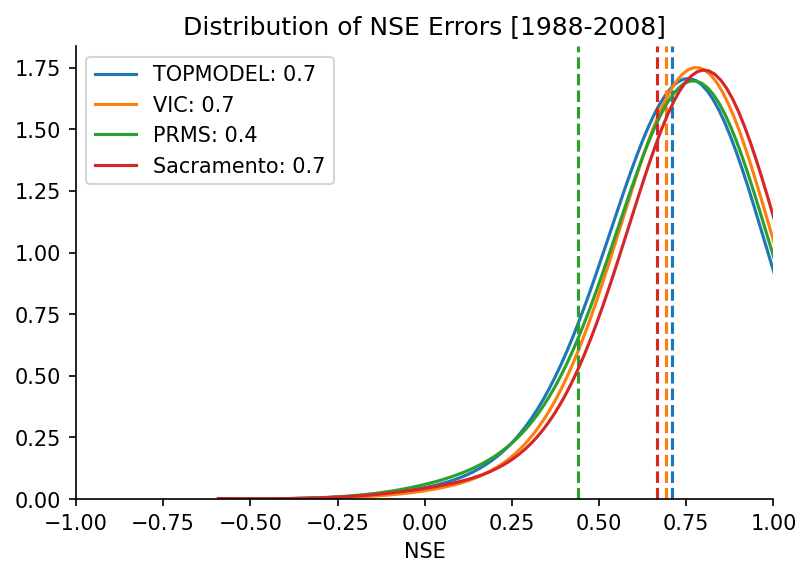

In [38]:
fig, ax = plt.subplots()
colors = sns.color_palette()

for ix, model in enumerate([c for c in nse_df.columns if c != "Name"]):
    sns.kdeplot(nse_df[model], ax=ax, label=f"{model}: {nse_df[model].mean():.1f}", bw=0.2, clip=(0, 1), color=colors[ix])
    ax.axvline(nse_df[model].mean(), ls='--', color=colors[ix])

ax.set_xlim([-1, 1])
ax.set_xlabel('NSE')

ax.set_title("Distribution of NSE Errors [1988-2008]")
sns.despine()

# Open the ML Experiments

In [41]:
print([d.name for d in (data_dir/'runs/').iterdir()])
# print([d.name for d in (data_dir/'runs').glob('*_less_vars*/*E015.csv')])

['ealstm_less_vars_2004_1607_1334', 'lstm_less_vars_1307_1717', 'ealstm_less_vars_2004_1707_1424', 'lstm_less_vars_2004_1507_1028', 'train_data.h5', 'train_data_scaler.p', 'lstm_ALL_vars_2004_2210_1035', 'lstm_all_vars_1998_2008_2210_110347', 'lstm_all_vars_1998_2008_2210_110727', 'lstm_all_vars_1998_2008_nh_2310_101443', 'lstm_all_vars_1998_2008_nh_2310_142625']


In [42]:
# lstm_less_vars = pd.read_csv(data_dir / "RUNOFF/lstm_less_vars/results_lstm_less_vars_1307_1717_E015.csv")
lstm_less_vars = pd.read_csv(data_dir / "runs/lstm_less_vars_2004_1507_1028/results_lstm_less_vars_2004_1507_1028_E015.csv")
lstm_less_vars["time"] = pd.to_datetime(lstm_less_vars["time"])

# RECENT MODEL RESULTS
lstm_df3 = pd.read_csv(data_dir / "runs/lstm_all_vars_1998_2008_nh_2310_101443/test/model_epoch030/lstm_all_vars_1998_2008_nh_2310_101443_E030.csv")
lstm_df3["time"] = pd.to_datetime(lstm_df3["time"])

In [43]:
ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
ealstm_less_vars["time"] = pd.to_datetime(ealstm_less_vars["time"])

In [47]:
lstm_preds = lstm_df3.set_index(["station_id", "time"]).to_xarray()
ealstm_preds = ealstm_less_vars.set_index(["station_id", "time"]).to_xarray()

In [45]:
# all_lstm = pd.read_csv(data_dir/"RUNOFF/less_vars_2004_2015/all_lstm_less_vars_2004_1507_1028_results.csv")
# all_ealstm = pd.read_csv(data_dir/"RUNOFF/less_vars_2004_2015/results_ealstm_less_vars_2004_1707_1424_E011.csv")

In [48]:
lstm_df = lstm_df3
lstm_df["time"] = pd.to_datetime(lstm_df["time"])
ealstm_df = ealstm_less_vars
ealstm_df["time"] = pd.to_datetime(ealstm_df["time"])

lstm_preds = lstm_df.set_index(["station_id", "time"]).to_xarray()
ealstm_preds = ealstm_df.set_index(["station_id", "time"]).to_xarray()

In [49]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse
from src.analysis.evaluation import _nse_func, _rmse_func, _r2_func

def error_func(preds_xr: xr.Dataset, error_str: str) -> pd.DataFrame:
    lookup = {
        "nse": _nse_func,
        "rmse": _rmse_func,
        "r2": _r2_func,
    }
    error_func = lookup[error_str]
    
    df = preds_xr.to_dataframe()
    df = df.dropna(how='any')
    df = df.reset_index().set_index("time")

    station_ids = df["station_id"].unique()
    errors = []
    for station_id in station_ids:
        d = df.loc[df["station_id"] == station_id]
        if error_str == "rmse":
            _error_calc = error_func(d["obs"].values, d["sim"].values, n_instances=d.size)
        else:
            _error_calc = error_func(d["obs"].values, d["sim"].values)
        errors.append(_error_calc)

    error = pd.DataFrame({"station_id": station_ids, error_str: errors})
    
    return error

In [50]:
errors = [ 
    error_func(ealstm_preds, "nse").set_index('station_id'),
    error_func(ealstm_preds, "r2").set_index('station_id'), 
    error_func(ealstm_preds, "rmse").set_index('station_id'),
]
ealstm_df = errors[0].join(errors[1].join(errors[2])).reset_index()

errors = [ 
    error_func(lstm_preds, "nse").set_index('station_id'),
    error_func(lstm_preds, "r2").set_index('station_id'), 
    error_func(lstm_preds, "rmse").set_index('station_id'),
]
lstm_df = errors[0].join(errors[1].join(errors[2])).reset_index()

# Get Static data Table

In [51]:
hydrologic_attributes = [
    "gauge_name",
    "q_mean",
    "runoff_ratio",
    "stream_elas",
    "slope_fdc",
    "baseflow_index",
    "baseflow_index_ceh",
    "hfd_mean",
    "Q5",
    "Q95",
    "high_q_freq",
    "high_q_dur",
    "low_q_freq",
    "low_q_dur",
]

rename = dict(zip(
    hydrologic_attributes,
    [
        "Name",
        "Mean Discharge (Q) ($mm^{-3} day^{-1}$)",
        "Runoff Ratio",
        "Stream elasticity",
        "Slope of the Flow-Duration-Curve",
        "Baseflow Index",
        "Baseflow Index CEH",
        "hfd_mean",
        "Q5 Discharge ($mm^{-3} day^{-1}$)",
        "Q95 Discharge ($mm^{-3} day^{-1}$)",
        "High Discharge (Q) Frequency",
        "High Discharge (Q) Duration",
        "Low Discharge (Q) Frequency",
        "Low Discharge (Q) Duration",
    ]
))

In [52]:
print(
    static[hydrologic_attributes]
    .sel(station_id=np.isin(static["station_id"], catchment_ids))
    .to_dataframe()
    .rename(columns=rename)
    .to_latex(float_format="%.2f")

)

\begin{tabular}{llrrrrrrrrrrrrr}
\toprule
{} &                     Name &  Mean Discharge (Q) (\$mm\textasciicircum \{-3\} day\textasciicircum \{-1\}\$) &  Runoff Ratio &  Stream elasticity &  Slope of the Flow-Duration-Curve &  Baseflow Index &  Baseflow Index CEH &  hfd\_mean &  Q5 Discharge (\$mm\textasciicircum \{-3\} day\textasciicircum \{-1\}\$) &  Q95 Discharge (\$mm\textasciicircum \{-3\} day\textasciicircum \{-1\}\$) &  High Discharge (Q) Frequency &  High Discharge (Q) Duration &  Low Discharge (Q) Frequency &  Low Discharge (Q) Duration \\
station\_id &                          &                                          &               &                    &                                   &                 &                     &           &                                    &                                     &                               &                              &                              &                             \\
\midrule
12002      &             

In [53]:
# sns.palplot(sns.color_palette())

In [54]:
# station_id = "12002"
# d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
# seasons = ds.sel(time=d.index)["time.season"].values
# d["season"] = seasons
# d.head()

# Plot the Scatter Plot and Time Series Errors

In [55]:
def plot_station_scatter(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    target_var: str = 'discharge_spec',
    station_name: Optional[str] = None,
    color_by_season: bool = None,
):
    # select station
    d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()
    
    if not color_by_season:
        # plot scatter
        ax.plot(d[target_var], d.preds, 'kx', alpha=0.6, label='Data Point')
    else:
        seasons = ds.sel(time=d.index)["time.season"].values
        d["season"] = seasons
        for ix, season in enumerate(d.season.unique()):
            ax.scatter(
                d.loc[d["season"] == season, target_var], 
                d.loc[d["season"] == season, "preds"], 
                color=sns.color_palette()[ix], 
                alpha=0.6, 
                label=season,
                marker="x"
            )
            sns.regplot(
                d.loc[d["season"] == season, target_var], 
                d.loc[d["season"] == season, "preds"], 
                color=sns.color_palette()[ix],
                ax=ax,
                scatter=False,
                ci=None,
            )
    # plot 1:1 line
    line_1_1_x = np.linspace(d[target_var].min(), d[target_var].max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line')

    ax.set_xlabel('Observed $[mm d^{-1} km^{-2}]$')
    ax.set_ylabel('Predicted $[mm d^{-1} km^{-2}]$')
    title = f'Station {station_id}' + f" {station_name}" if station_name is not None else f'Station {station_id}'
    ax.set_title(title)

    ax.legend();
    
    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax


def plot_station(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    station_name: Optional[str] = None,
    plot_years: Optional[List[int]] = None,
):
    """Plot the Observed vs. Preds for the station_id"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    # plot the station
    if plot_years is None:
        df.query(f"station_id == '{station_id}'").drop(columns='station_id').plot(ax=ax)
    else:
        (
            df.loc[np.isin(df.index.year, plot_years)]
            .query(f"station_id == '{station_id}'")
            .drop(columns='station_id').plot(ax=ax)
        )
    
    # get the error metrics
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")
    
    return fig, ax

In [56]:
# fig, ax = plt.subplots()
# plot_station_scatter(df, station_id, metrics_df, ax, color_by_season=True)

In [57]:
df = lstm_less_vars.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1)
metrics_df = lstm_df

# test_stations = ['22007', '27049', '28018', '31021', '31023', '34004', '35003', '39022', '41029', '51001', '55025', '57004', '83010']
catchment_ids = ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]

plot_years = [2011]
scale = 0.8

def plot_catchment_time_series(
    df: pd.DataFrame,
    metrics_df: pd.DataFrame,
    catchment_ids: List[str],
    catchment_names: List[str],
    plot_years: List[int] = [2011],
    scale: float = 0.8,
    color_by_season: bool = False,
):
    n_plots = len(catchment_ids)
    station_map = dict(zip(catchment_ids, catchment_names))
    fig, axs = plt.subplots(n_plots, 2, figsize=(12*scale, 6*scale*n_plots))

    for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
    #     fig, axs = plt.subplots(1, 2, figsize=(12*scale, 6*scale))
        try:
            plot_station(df, station_id, metrics_df, ax=axs[ix, 0], station_name=station_name, plot_years=plot_years)
            plot_station_scatter(df, station_id, metrics_df, axs[ix, 1], color_by_season=color_by_season)
        except IndexError:
            # the axes are one dimensional
            plot_station(df, station_id, metrics_df, ax=axs[0], station_name=station_name, plot_years=plot_years)
            plot_station_scatter(df, station_id, metrics_df, axs[1], color_by_season=color_by_season)
        except TypeError:
            print(f"** {station_name} data does not exist in the predictions! **")

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    return fig, axs

In [58]:
def get_error_df(model: str, fuse_errors: pd.DataFrame) -> pd.DataFrame:
    all_models = ["TOPMODEL", "VIC", "PRMS", "Sacramento"]
    assert model in all_models
    remove_models = [m for m in all_models if m != model]
    error_df = fuse_errors.drop(remove_models, axis=1, level=1).swaplevel(axis=1).sort_index(axis=1).droplevel(axis=1, level=0)
    rename_cols = pd.io.parsers.ParserBase({'names': error_df.columns})._maybe_dedup_names(error_df.columns)
    error_df.columns = [n if n != "nse" else "Name" for n in rename_cols]
    return error_df.rename({"nse.1": "nse"}, axis=1)


topmodel = fuse_data[["obs", "SimQ_TOPMODEL"]].to_dataframe().reset_index()
vic = fuse_data[["obs", "SimQ_ARNOVIC"]].to_dataframe().reset_index()
prms = fuse_data[["obs", "SimQ_PRMS"]].to_dataframe().reset_index()
sacramento = fuse_data[["obs", "SimQ_SACRAMENTO"]].to_dataframe().reset_index()

top_error = get_error_df("TOPMODEL", fuse_errors)
vic_error = get_error_df("VIC", fuse_errors)
prms_error = get_error_df("PRMS", fuse_errors)
sac_error = get_error_df("Sacramento", fuse_errors)

In [59]:
lstm_less_vars.head()

,station_id,time,obs,sim
0,1001,2004-01-01,9.16,10.026257
1,1001,2004-01-02,6.23,5.819096
2,1001,2004-01-03,5.60,5.267475
3,1001,2004-01-04,4.45,5.064303
4,1001,2004-01-05,4.46,5.131446


# Get the median basins etc.

In [60]:
assert (data_dir / "RUNOFF/all_nse.csv").exists()
assert (data_dir / "RUNOFF/all_bias.csv").exists()

all_nse = pd.read_csv((data_dir / "RUNOFF/all_nse.csv"))
all_bias = pd.read_csv((data_dir / "RUNOFF/all_bias.csv"))

all_nse.head()

,Station ID,Name,TOPMODEL,VIC,PRMS,Sacramento,EALSTM,LSTM,CLASSIC,JULES
0,12002,Dee at Park,0.614672,0.682167,0.653526,0.675102,0.858937,0.862713,0.55,0.51
1,15006,Tay at Ballathie,0.786324,0.863796,0.841181,0.857075,0.924273,0.941218,0.46,0.64
2,27009,Ouse at Skelton,0.850947,0.882587,0.878732,0.897445,0.883401,0.900021,0.80,0.69
3,27034,Ure at Kilgram Bridge,0.823744,0.830399,0.828210,0.836142,0.872704,0.876001,0.78,0.75
4,27041,Derwent at Buttercrambe,0.765636,0.854433,0.849083,0.892766,0.747545,0.772363,0.65,0.49


In [61]:
median = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].median()]
min_ = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].min()]
max_ = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].max()]

median_station = (median["Station ID"].values, median.Name.values)
min_station = (min_["Station ID"].values, min_.Name.values)
max_station = (max_["Station ID"].values, max_.Name.values)

pd.concat([median, min_, max_])

,Station ID,Name,TOPMODEL,VIC,PRMS,Sacramento,EALSTM,LSTM,CLASSIC,JULES
7,43021,Avon at Knapp Mill,0.551778,0.910636,0.828939,0.890455,0.585134,0.878800,0.60,-0.07
6,39081,Ock at Abingdon,0.712582,0.746671,0.761862,0.830130,0.428313,0.545118,0.80,-0.21
1,15006,Tay at Ballathie,0.786324,0.863796,0.841181,0.857075,0.924273,0.941218,0.46,0.64


In [62]:
summary_stations = np.vstack([median_station, min_station, max_station]).reshape(3, 2)

# LSTM Errors

In [63]:
PLOT_ALL = False

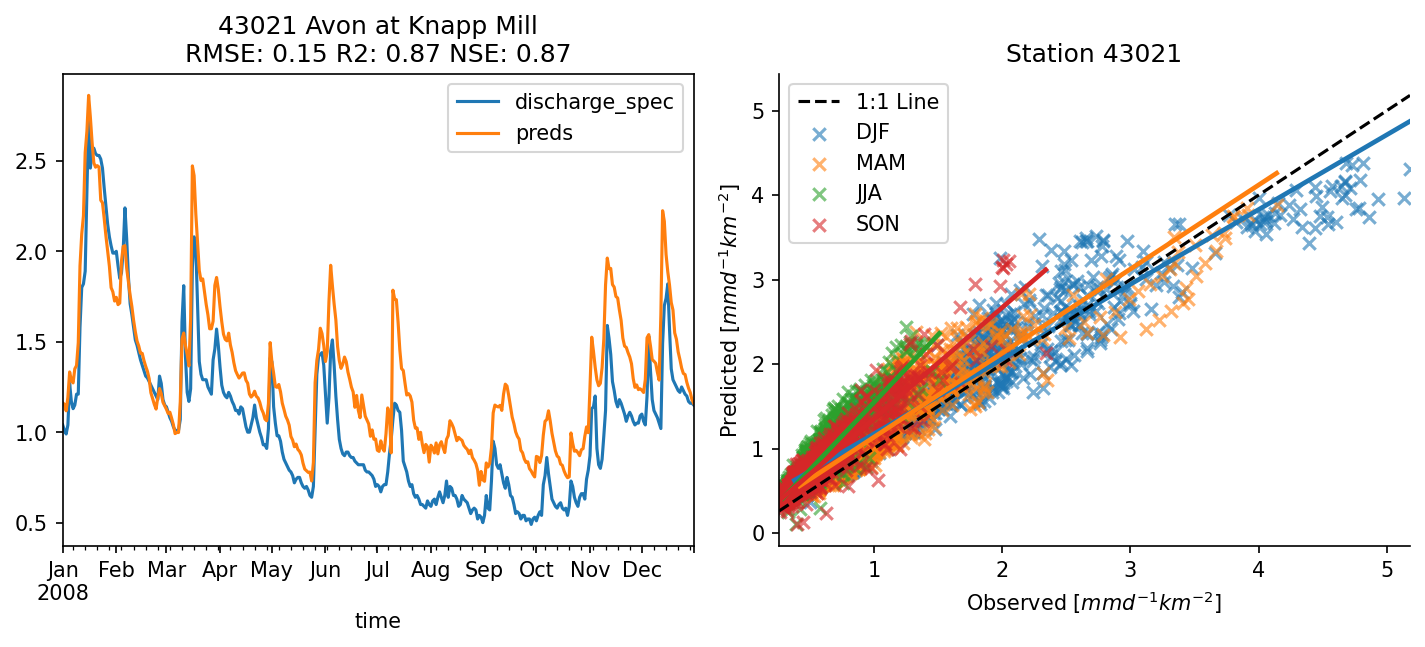

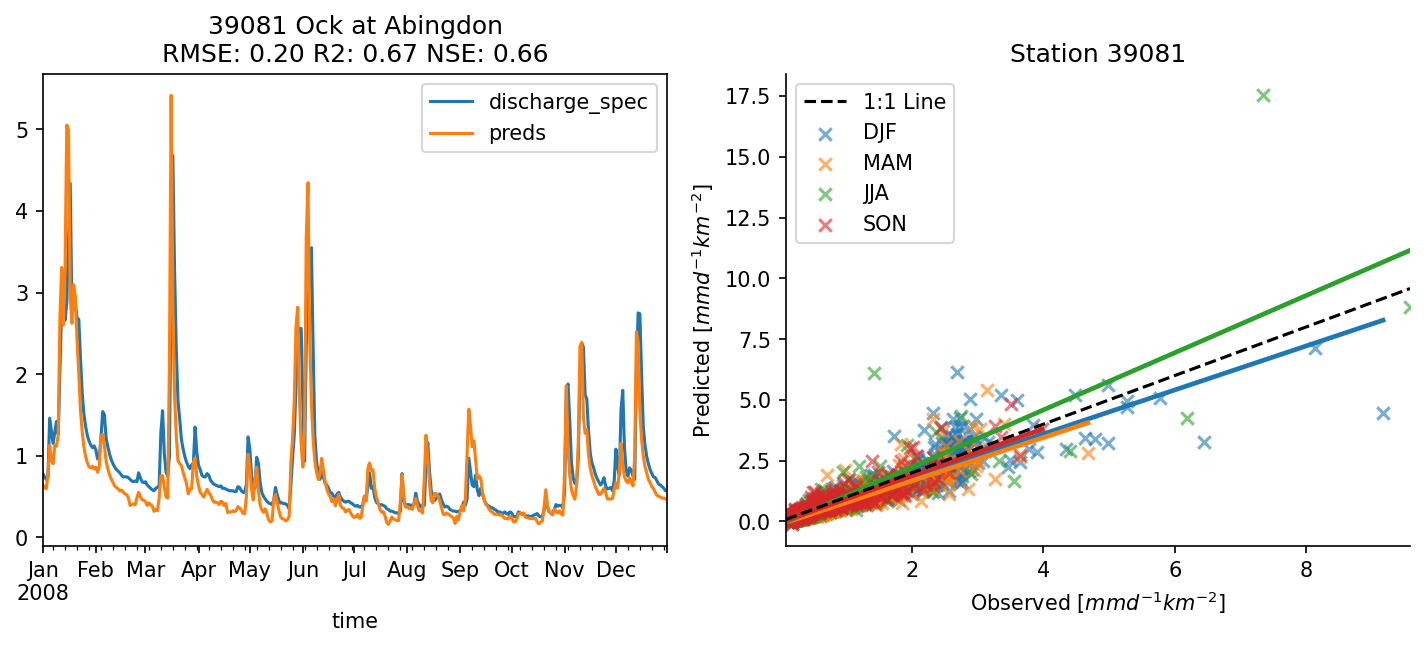

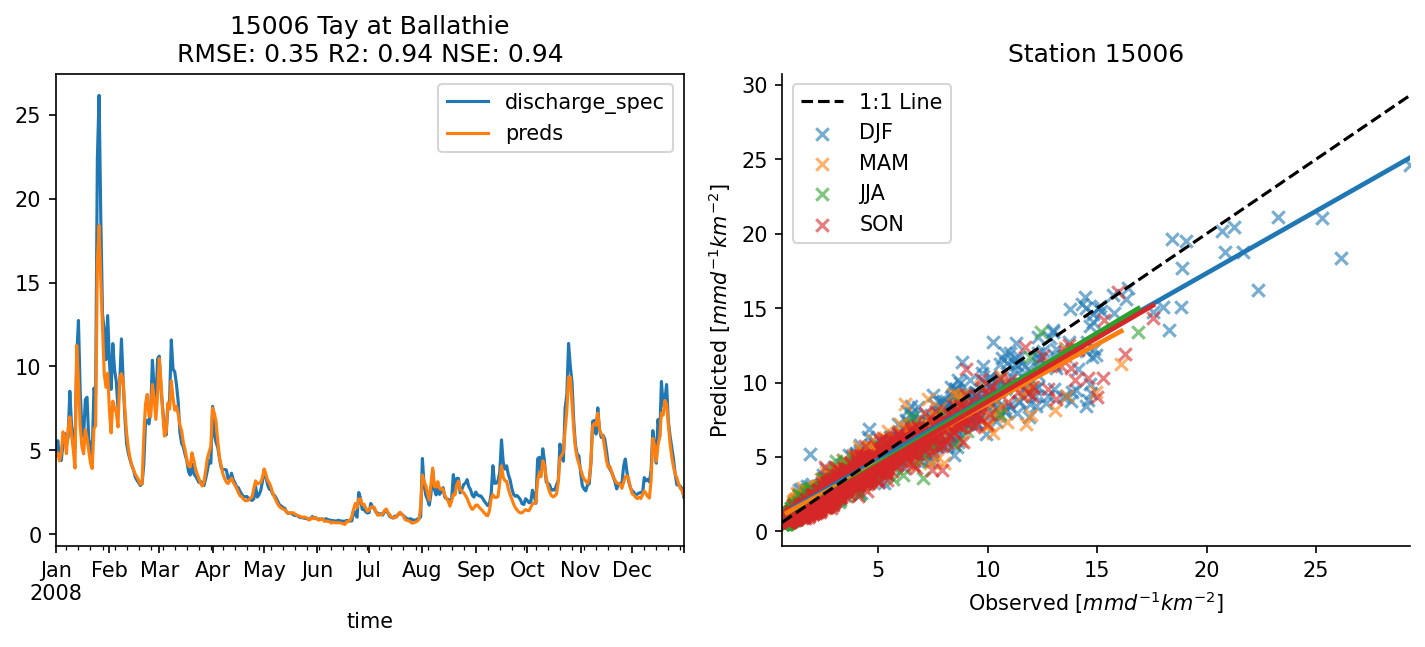

In [64]:
if PLOT_ALL:
    fig, axs = plot_catchment_time_series(
        df=lstm_less_vars.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1),
        metrics_df=lstm_df,
        catchment_ids=catchment_ids,
        catchment_names=catchment_names,
        plot_years=[2008],
        color_by_season=True,
    );
    
else:
    for idx, name in summary_stations:
        fig, axs = plot_catchment_time_series(
            df=lstm_less_vars.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1),
            metrics_df=lstm_df,
            catchment_ids=[idx],
            catchment_names=[name],
            plot_years=[2008],
            color_by_season=True,
        );
    

# Conceptual Errors

In [65]:
if PLOT_ALL:

    fig, axs = plot_catchment_time_series(
        df=topmodel.set_index("time").rename({"obs": "discharge_spec", "SimQ_TOPMODEL": "preds"}, axis=1),
        metrics_df=top_error,
        catchment_ids=catchment_ids,
        catchment_names=catchment_names,
        plot_years=[2008],
        color_by_season=True,
    );
    fig.suptitle("TOPMODEL");

In [66]:
if PLOT_ALL:

    fig, axs = plot_catchment_time_series(
        df=sacramento.set_index("time").rename({"obs": "discharge_spec", "SimQ_SACRAMENTO": "preds"}, axis=1),
        metrics_df=sac_error,
        catchment_ids=catchment_ids,
        catchment_names=catchment_names,
        plot_years=[2008],
        color_by_season=True,
    );
    fig.suptitle("SACRAMENTO");

In [67]:
if PLOT_ALL:
    fig, axs = plot_catchment_time_series(
        df=vic.set_index("time").rename({"obs": "discharge_spec", "SimQ_ARNOVIC": "preds"}, axis=1),
        metrics_df=vic_error,
        catchment_ids=catchment_ids,
        catchment_names=catchment_names,
        plot_years=[2008],
        color_by_season=True,
    );
    fig.suptitle("VIC");

In [68]:
if PLOT_ALL:
    fig, axs = plot_catchment_time_series(
        df=prms.set_index("time").rename({"obs": "discharge_spec", "SimQ_PRMS": "preds"}, axis=1),
        metrics_df=prms_error,
        catchment_ids=catchment_ids,
        catchment_names=catchment_names,
        plot_years=[2008],
        color_by_season=True,
    );
    fig.suptitle("PRMS");

# Confirm the NSE calculations

In [ ]:
from src.analysis.evaluation import _nse_func

In [ ]:
lstm_less_vars.head()

In [ ]:
out = {}
for station in lstm_less_vars.station_id.unique():
    out[station] = _nse_func(
        lstm_less_vars.loc[lstm_less_vars["station_id"] == station, "obs"].values, 
        lstm_less_vars.loc[lstm_less_vars["station_id"] == station, "sim"].values
    )

In [ ]:
nse = pd.DataFrame(out, index=[0]).T.reset_index().rename({"index": "station_id", 0: "nse"}, axis=1)
nse

In [ ]:
display(nse.set_index("station_id")["nse"].head())
display(metrics_df.set_index("station_id")["nse"].head())